## Оглавление
[1. Описание данных](#1.-Описание-данных)<br>
[2. Краткий разведочный анализ](#2.-Краткий-разведочный-анализ)<br>
[3. Подготовка данных к моделированию](#3.-Подготовка-данных-к-моделированию)<br>
[4. Построение моделей бинарной классификации](#4.-Построение-моделей-бинарной-классификации)<br>
[5. Сравнение качества моделей](#5.-Сравнение-качества-моделей) <br>

## 1. Описание данных

In [1]:
#импортируем необходимые библиотеки:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer


In [2]:
#загрузим данные и объединим датафреймы:
train_identity = pd.read_csv('train_identity.csv')
train_transaction = pd.read_csv('train_transaction.csv')
test_identity = pd.read_csv('train_identity.csv')
test_transaction = pd.read_csv('train_transaction.csv')
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [3]:
#удалим лишние датафреймы из памяти
del train_identity, test_transaction, train_transaction, test_identity

In [4]:
#удостоверимся, что по тренировочному и тестовому набору совпадает количество столбцов
print(f'Размер тренировочного датасета: {train.shape} \nРазмер тестового датасета: {test.shape}')

Размер тренировочного датасета: (590540, 434) 
Размер тестового датасета: (590540, 434)


In [5]:
#Посмотрим сколько колонок с нулевыми значениями
print(f'Количество столбцов с нулевыми значениями: \ntrain: {train.isnull().any().sum()} \ntest: {test.isnull().any().sum()}')

Количество столбцов с нулевыми значениями: 
train: 414 
test: 414


## 2. Краткий разведочный анализ

Я не буду проводить глубокого разведочного анализа (EDA), ограничусь ключевыми переменными. Остальные выводы можно сделать по многочисленным EDA, имеющимся на сайте kaggle. Посмотрим:
1. Распределение целевой переменной (isFraud)
2. Категориальных переменных ('card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain')

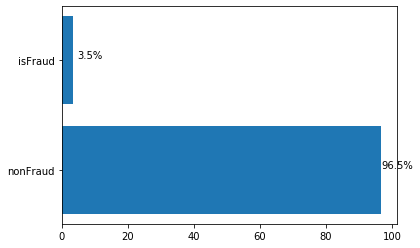

In [7]:
#посмотрим на соотношение классов 
N_ROWS = train.shape[0]
fig, ax = plt.subplots()
ax.barh(['nonFraud', 'isFraud'], 
         train.groupby('isFraud')['isFraud'].agg('count') * 100 / N_ROWS)
rects = ax.patches
labels = np.around(train.groupby('isFraud')['isFraud'].agg('count').values * 100 / N_ROWS, 1)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_width() + 5, rect.get_y() + height/2, f'{str(label)}%', ha='center', va='bottom', color='black')

Видим, что выборка несбалансирована по классам, будем использовать метрику roc_auc для оценки качества моделей

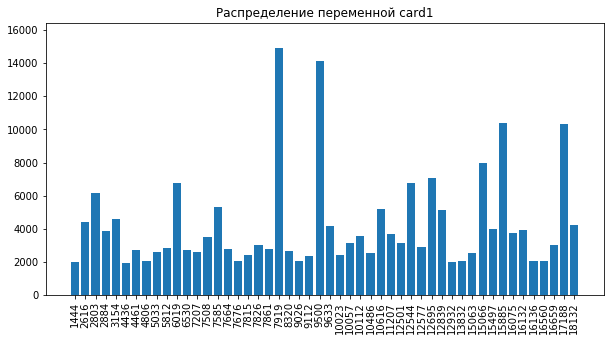

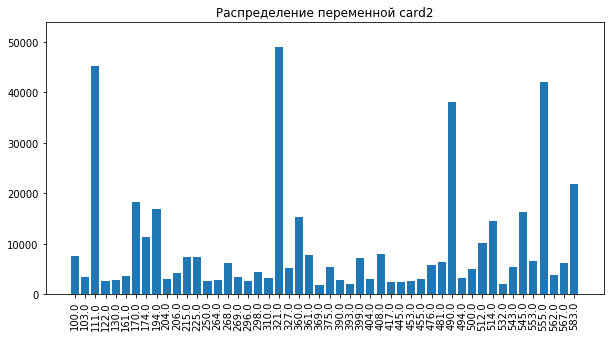

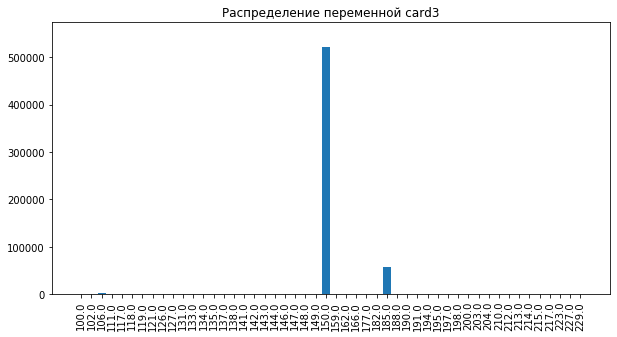

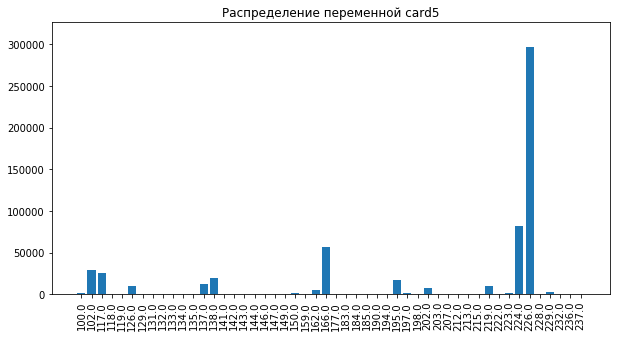

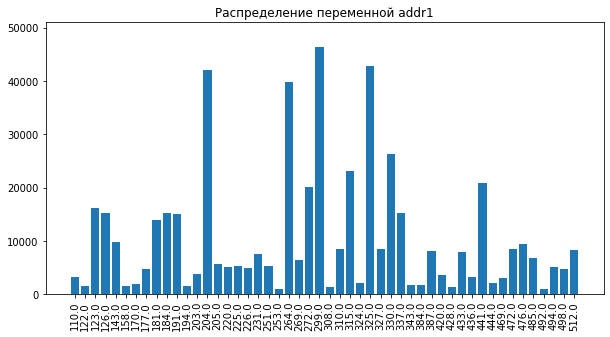

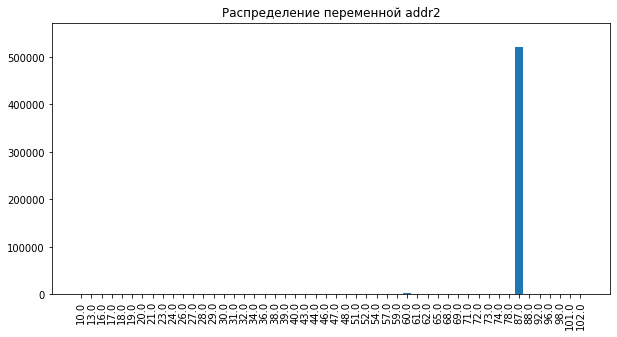

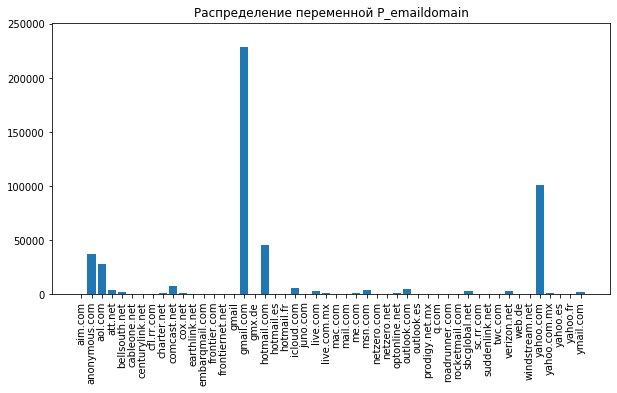

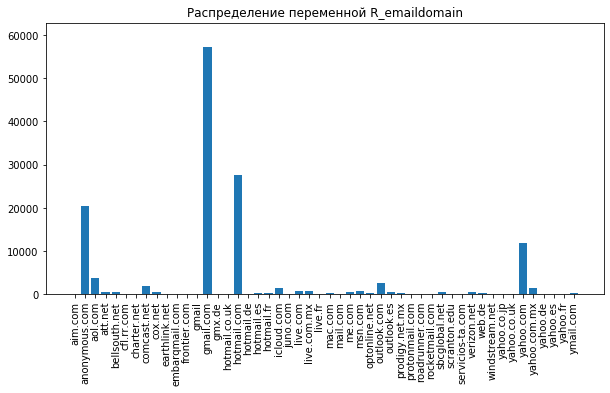

In [8]:
categorical_columns = ['card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain']
for column in categorical_columns:
    fig, ax = plt.subplots(figsize=(10,5))
    ax.bar(train[column].value_counts(dropna=True).iloc[:50].index.sort_values().values.astype('str'),
           train[column].value_counts(dropna=True).iloc[:50].sort_index().values)
    y_max = train[column].value_counts(dropna=True).values.max()
    ax.set_ylim(0, y_max + y_max*0.1)
    plt.xticks(rotation='vertical')
    ax.set_title(f'Распределение переменной {column}')

## 3. Подготовка данных к моделированию

В датасетах большинство столбцов имеют нулевые значения (414 из 434). Поскольку задание тестовое, будем придерживаться несложной стратегии - столбцы, в которых количество нулевых значений превышает 80% выбросим из модели, там, где меньше будем заменять NAN на медиану. Также отбросим признаки, количество уникальных объектов в которых превышает 90% (не учитывая таргет)

In [9]:
#отбираем в список колонки, где > 80% NaN:
exclude_cols_train1 = []
exclude_cols_test1 = []
for column in train.columns:
    if train[column].isnull().sum() / N_ROWS > 0.8:
        exclude_cols_train1.append(column)
    if test[column].isnull().sum() / N_ROWS > 0.8:
        exclude_cols_test1.append(column)

In [10]:
#также отберем колонки, которые больше, чем на 90% заполнены одними и теми же значениями (исключая таргет):
exclude_cols_train2 = []
exclude_cols_test2 = []
for column in train.columns:
    if column == 'isFraud':
        continue
    if train[column].value_counts(dropna=False, normalize=True).values[0] > 0.9:
        exclude_cols_train2.append(column)
    if test[column].value_counts(dropna=False, normalize=True).values[0] > 0.9:
        exclude_cols_test2.append(column)

In [11]:
#объединим все колонки на удаление в один список
exclude_cols = list(set(exclude_cols_train2 + exclude_cols_test2 + exclude_cols_train1 + exclude_cols_test1))

In [12]:
print(f'{exclude_cols}, \nВсего колонок: {len(exclude_cols)}')

['V284', 'id_10', 'V162', 'V296', 'V143', 'V286', 'V104', 'V123', 'id_23', 'V156', 'id_32', 'V137', 'V146', 'id_08', 'V337', 'V333', 'V300', 'id_07', 'V322', 'V309', 'V135', 'V112', 'V159', 'V125', 'V147', 'V161', 'id_21', 'V281', 'V101', 'V338', 'V301', 'V323', 'V334', 'V115', 'V117', 'V157', 'D14', 'id_30', 'V148', 'dist2', 'V145', 'id_03', 'V321', 'V119', 'id_09', 'V311', 'V319', 'V105', 'V153', 'id_26', 'V109', 'V163', 'V295', 'V332', 'V329', 'V339', 'D7', 'V122', 'V297', 'D8', 'V108', 'V121', 'V129', 'C3', 'V299', 'V152', 'V328', 'V103', 'id_04', 'V320', 'V134', 'V149', 'V331', 'V102', 'V141', 'V164', 'V98', 'id_25', 'V325', 'V113', 'V326', 'V290', 'V107', 'id_18', 'V336', 'id_24', 'V140', 'V151', 'id_22', 'V166', 'V154', 'id_27', 'V106', 'D6', 'V335', 'D12', 'V324', 'V133', 'V144', 'V132', 'id_34', 'D9', 'V330', 'V124', 'V110', 'V118', 'V316', 'D13', 'V327', 'V160', 'V114', 'V150', 'V318', 'V116', 'V158', 'V111', 'id_33', 'V136', 'V305', 'V142', 'V120', 'V298', 'V139', 'id_14', '

In [13]:
#удалим все отобранные колонки с признаками из тренировочного и тестово датафреймов
train = train.drop(exclude_cols, axis=1)
test = test.drop(exclude_cols, axis=1)

Согласно документации на сайте kaggle.com к категориальным переменным относятся следующие (исключая признаки, попавшие в exclude_cols):

ProductCD, card1, card2, card3, card4, card5, card6, addr1, addr2, P_emaildomain, R__emaildomain, M1, M2, M3, M4, M5, M6, M7, M8, M9, DeviceType, DeviceInfo, id_12, id_13, id_15, id_16, id_17, id_19, id_20, id_28, id_29, id_31, id_35, id_36, id_37, id_38

Такие переменные нужно закодировать. Сделаем это с помощью LabelEncoder()

In [14]:
categorical_columns = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 
                       'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 
                       'DeviceType', 'DeviceInfo', 'id_12', 'id_13', 'id_15', 'id_16', 'id_17', 'id_19', 
                       'id_20', 'id_28', 'id_29', 'id_31',
                       'id_35', 'id_36', 'id_37', 'id_38']
for column in categorical_columns:
    labelencoder = LabelEncoder()
    train[column] = labelencoder.fit_transform(train[column].astype('str').values)

In [15]:
for column in categorical_columns:
    labelencoder = LabelEncoder()
    test[column] = labelencoder.fit_transform(test[column].astype('str').values)

In [16]:
#посмотрим, что получилось:
train.loc[:5, ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 
                       'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 
                       'DeviceType', 'DeviceInfo', 'id_12', 'id_13', 'id_15', 'id_16', 'id_17', 'id_19', 
                       'id_20', 'id_29', 'id_31',
                       'id_35', 'id_36', 'id_37', 'id_38']]

,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,...,id_16,id_17,id_19,id_20,id_29,id_31,id_35,id_36,id_37,id_38
0,4,3417,500,42,1,38,1,166,65,32,...,2,104,522,394,2,103,2,2,2,2
1,4,7922,303,42,2,2,1,173,65,16,...,2,104,522,394,2,103,2,2,2,2
2,4,9383,389,42,4,58,2,178,65,36,...,2,104,522,394,2,103,2,2,2,2
3,4,6991,466,42,2,14,2,282,65,54,...,2,104,522,394,2,103,2,2,2,2
4,1,9262,413,42,2,2,1,241,65,16,...,1,59,400,32,1,124,1,0,1,1
5,4,10366,454,42,4,108,2,132,65,16,...,2,104,522,394,2,103,2,2,2,2


In [17]:
# Сохраним отдельно таргет и признаки
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionID', 'TransactionDT'], axis=1)
Y = train.sort_values('TransactionDT')['isFraud']
X_test = test.sort_values('TransactionDT').drop(['isFraud', 'TransactionID', 'TransactionDT'], axis=1)
Y_test = test.sort_values('TransactionDT')['isFraud']

In [18]:
del train
del test

In [19]:
#заполним nan в датасетах с признаками на медиану с помощью SimpleImputer()
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)
X_test = imputer.fit_transform(X)

## 4. Построение моделей бинарной классификации

Построим модели классификации на основе следующих алгоритмов:

1. RandomForestClassifier
2. LGBMClassifier
3. CatBoostClassifier
4. XGBClassifier

In [20]:
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as ltb
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [130]:
# RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=40, min_samples_leaf=2, class_weight={0:.2, 1:.8}, random_state=17)
rfc_model = rfc.fit(X, Y)

In [129]:
rfc_predict = rfc.predict(X_test)
rfc_roc_auc = roc_auc_score(Y_test, rfc_predict)
print(f'ROC_AUC по RandomForestClassifier: {rfc_roc_auc}')

ROC_AUC по RandomForestClassifier: 0.9181287320637402


In [73]:
# LGBMClassifier
params = {'num_leaves': 300,
          'min_child_samples': 15,
          'objective': 'binary',
          'max_depth': 30,
          'learning_rate': 0.2,
          "metric": 'auc'
}
lgbm = ltb.LGBMClassifier(**params, random_state=17)
lgbm_model = lgbm.fit(X, Y)

In [74]:
lgbm_predict = lgbm_model.predict(X_test)
lgbm_roc_auc = roc_auc_score(Y_test, lgbm_predict)
print(f'ROC_AUC по LGBMClassifier {lgbm_roc_auc}')

ROC_AUC по LGBMClassifier 0.9307607931851373


In [110]:
# CatBoostClassifier
cb = CatBoostClassifier(iterations=500,
                         learning_rate=0.8,
                         l2_leaf_reg=1,
                         depth=8,
                         loss_function= 'Logloss',
                         eval_metric='AUC',
                         random_seed=17
) 
cb_model = cb.fit(X, Y)

0:	total: 579ms	remaining: 4m 48s
1:	total: 1.16s	remaining: 4m 47s
2:	total: 1.73s	remaining: 4m 46s
3:	total: 2.44s	remaining: 5m 2s
4:	total: 3.21s	remaining: 5m 17s
5:	total: 3.91s	remaining: 5m 21s
6:	total: 4.69s	remaining: 5m 30s
7:	total: 5.58s	remaining: 5m 43s
8:	total: 6.92s	remaining: 6m 17s
9:	total: 7.73s	remaining: 6m 18s
10:	total: 8.46s	remaining: 6m 15s
11:	total: 9.19s	remaining: 6m 13s
12:	total: 9.76s	remaining: 6m 5s
13:	total: 10.4s	remaining: 6m 1s
14:	total: 11s	remaining: 5m 56s
15:	total: 11.7s	remaining: 5m 52s
16:	total: 12.3s	remaining: 5m 50s
17:	total: 12.9s	remaining: 5m 45s
18:	total: 13.5s	remaining: 5m 42s
19:	total: 14.1s	remaining: 5m 38s
20:	total: 14.8s	remaining: 5m 38s
21:	total: 15.7s	remaining: 5m 41s
22:	total: 16.3s	remaining: 5m 38s
23:	total: 17s	remaining: 5m 37s
24:	total: 17.6s	remaining: 5m 34s
25:	total: 18.4s	remaining: 5m 36s
26:	total: 19.2s	remaining: 5m 37s
27:	total: 19.9s	remaining: 5m 36s
28:	total: 20.8s	remaining: 5m 37s
29

230:	total: 3m 2s	remaining: 3m 32s
231:	total: 3m 3s	remaining: 3m 32s
232:	total: 3m 4s	remaining: 3m 31s
233:	total: 3m 5s	remaining: 3m 30s
234:	total: 3m 5s	remaining: 3m 29s
235:	total: 3m 6s	remaining: 3m 28s
236:	total: 3m 7s	remaining: 3m 27s
237:	total: 3m 8s	remaining: 3m 27s
238:	total: 3m 8s	remaining: 3m 26s
239:	total: 3m 9s	remaining: 3m 25s
240:	total: 3m 10s	remaining: 3m 24s
241:	total: 3m 11s	remaining: 3m 24s
242:	total: 3m 12s	remaining: 3m 23s
243:	total: 3m 12s	remaining: 3m 22s
244:	total: 3m 13s	remaining: 3m 21s
245:	total: 3m 14s	remaining: 3m 20s
246:	total: 3m 15s	remaining: 3m 20s
247:	total: 3m 16s	remaining: 3m 19s
248:	total: 3m 17s	remaining: 3m 19s
249:	total: 3m 18s	remaining: 3m 18s
250:	total: 3m 19s	remaining: 3m 17s
251:	total: 3m 19s	remaining: 3m 16s
252:	total: 3m 20s	remaining: 3m 15s
253:	total: 3m 21s	remaining: 3m 15s
254:	total: 3m 22s	remaining: 3m 14s
255:	total: 3m 23s	remaining: 3m 13s
256:	total: 3m 23s	remaining: 3m 12s
257:	total:

456:	total: 6m 6s	remaining: 34.5s
457:	total: 6m 7s	remaining: 33.7s
458:	total: 6m 8s	remaining: 32.9s
459:	total: 6m 8s	remaining: 32.1s
460:	total: 6m 9s	remaining: 31.3s
461:	total: 6m 10s	remaining: 30.5s
462:	total: 6m 11s	remaining: 29.7s
463:	total: 6m 12s	remaining: 28.9s
464:	total: 6m 12s	remaining: 28.1s
465:	total: 6m 13s	remaining: 27.3s
466:	total: 6m 14s	remaining: 26.5s
467:	total: 6m 15s	remaining: 25.7s
468:	total: 6m 15s	remaining: 24.9s
469:	total: 6m 16s	remaining: 24s
470:	total: 6m 17s	remaining: 23.2s
471:	total: 6m 18s	remaining: 22.4s
472:	total: 6m 18s	remaining: 21.6s
473:	total: 6m 19s	remaining: 20.8s
474:	total: 6m 20s	remaining: 20s
475:	total: 6m 21s	remaining: 19.2s
476:	total: 6m 21s	remaining: 18.4s
477:	total: 6m 22s	remaining: 17.6s
478:	total: 6m 23s	remaining: 16.8s
479:	total: 6m 24s	remaining: 16s
480:	total: 6m 25s	remaining: 15.2s
481:	total: 6m 26s	remaining: 14.4s
482:	total: 6m 27s	remaining: 13.6s
483:	total: 6m 28s	remaining: 12.8s
484

In [114]:
cb_predict = cb_model.predict(X_test)
cb_roc_auc = roc_auc_score(Y_test, cb_predict)
print(f'ROC_AUC по CatBoostClassifier {cb_roc_auc_score}')

ROC_AUC по CatBoostClassifier 0.9186290798468706


In [38]:
#XGBClassifier
xgb = XGBClassifier(eta=0.1, min_child_weight=3, n_estimators=50, subsample=0.1, cv=5, random_state=17)
xgb_model = xgb.fit(X, Y)

In [112]:
xgb_predict = xgb_model.predict(X_test)
xgb_roc_auc = roc_auc_score(xgb_predict, Y_test)
print(f'ROC_AUC по XGBClassifier {xgb_roc_auc}')

ROC_AUC по XGBClassifier 0.9368394802675114


## 5. Сравнение качества моделей 

In [127]:
#добавим метрики по моделям в список
metrics = np.array([rfc_roc_auc, lgbm_roc_auc, cb_roc_auc, xgb_roc_auc])
#добавим рассчитанные метрики по каждому набору признаков в датафрейм
model_metrics = pd.DataFrame(metrics,
                             index=['RFC', 'LGBM', 'CatBoost', 'XGBoost'],
                             columns=['roc_auc_score'])
model_metrics

,roc_auc_score
RFC,0.919134
LGBM,0.930761
CatBoost,0.918629
XGBoost,0.936839


Лучший показатель по метрике roc_auc_score у модели XGBClassifier, дополнительно распечатаем по нему матрицу ошибок и отчет

In [131]:
from sklearn.metrics import confusion_matrix, classification_report

print('XGB модель')
print(f'\n{confusion_matrix(Y_test, xgb_predict)}')
print(classification_report(Y_test, xgb_predict, target_names=['Non-Fraud', 'IsFraud']))

XGB модель

[[569089    788]
 [ 13777   6886]]
              precision    recall  f1-score   support

   Non-Fraud       0.98      1.00      0.99    569877
     IsFraud       0.90      0.33      0.49     20663

    accuracy                           0.98    590540
   macro avg       0.94      0.67      0.74    590540
weighted avg       0.97      0.98      0.97    590540



Как видно из отчетов, алгоритм делает сравнительно мало ошибок первого рода (ложноположительных), т.е. алгоритм редко определяет мошенническими схемами те, которые ими на самом деле не являются). Больше алгоритм делает ложноотрицательных ошибок (2-го рода), определяя 13 777 мошенических транзакций (67%), как немошеннические. Улучшить модель можно за счет более глубокой проработки признаков, использования grid_search для подбора гиперпараметров моделей